In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds

2024-06-27 14:13:34.152851: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 14:13:34.179752: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 14:13:34.179786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 14:13:34.179813: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 14:13:34.186455: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-27 14:13:34.187102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
train_ds, val_ds = tfds.load("cifar100", split=["train[:80%]", "train[80%:]"])
test_ds = tfds.load("cifar100", split="test")
len(train_ds), len(val_ds), len(test_ds)

(40000, 10000, 10000)

2024-06-27 14:13:36.497206: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(<matplotlib.image.AxesImage at 0x70f76867e750>,
 <tf.Tensor: shape=(), dtype=int64, numpy=12>)

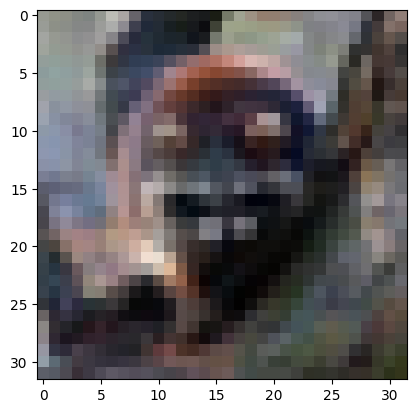

In [3]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['coarse_label']

In [4]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['coarse_label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            .batch(256)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [5]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 32)          0

In [8]:
# create resnet-like model?

def create_model():
    def block(x, filters, kernel_size):
        y = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        y = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
        y = tf.keras.layers.Add()([x, y])
        y = tf.keras.layers.Activation('relu')(y)
        return y

    filters_and_kernels = [
        (128, (2,2)),
        (64, (2,2)),
        (32, (4,4)),
    ]

    x = tf.keras.layers.Input((32, 32, 3), dtype=tf.float32)
    y = tf.keras.layers.Conv2D(filters_and_kernels[0][0], filters_and_kernels[0][1], padding='same')(x)
    for filters, kernel_size in filters_and_kernels:
        y = block(y, filters, kernel_size)
        y = tf.keras.layers.Dropout(0.1)(y)
        y = tf.keras.layers.MaxPool2D((2, 2))(y)
    
    y = tf.keras.layers.Flatten()(y)

    return tf.keras.Model(inputs=x, outputs=y, name='cifar-model')

In [8]:
history = model.fit(
    train, 
    epochs=100, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
)

Epoch 1/100


157/157 [==============================] - 15s 90ms/step - loss: 2.6939 - accuracy: 0.1715 - val_loss: 2.4482 - val_accuracy: 0.2593
Epoch 2/100
157/157 [==============================] - 13s 86ms/step - loss: 2.3769 - accuracy: 0.2699 - val_loss: 2.2526 - val_accuracy: 0.3131
Epoch 3/100
157/157 [==============================] - 14s 86ms/step - loss: 2.2420 - accuracy: 0.3088 - val_loss: 2.1750 - val_accuracy: 0.3349
Epoch 4/100
157/157 [==============================] - 14s 87ms/step - loss: 2.1588 - accuracy: 0.3335 - val_loss: 2.1004 - val_accuracy: 0.3555
Epoch 5/100
157/157 [==============================] - 14s 88ms/step - loss: 2.1029 - accuracy: 0.3459 - val_loss: 2.0389 - val_accuracy: 0.3757
Epoch 6/100
157/157 [==============================] - 14s 88ms/step - loss: 2.0515 - accuracy: 0.3641 - val_loss: 2.0015 - val_accuracy: 0.3881
Epoch 7/100
157/157 [==============================] - 14s 88ms/step - loss: 2.0078 - accuracy: 0.3775 - val_loss: 1.9717 - val_accuracy: 0.39

In [9]:
model.evaluate(test)

20/20 [==============================] - 1s 35ms/step - loss: 1.7020 - accuracy: 0.4734


[1.702022671699524, 0.4733999967575073]

Text(0.5, 1.0, 'Accuracy on CIFAR-100')

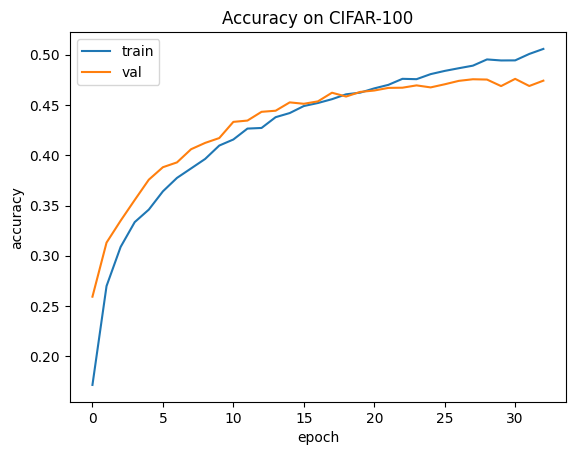

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on CIFAR-100')